In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
from scipy.optimize import minimize
from scipy.optimize import basinhopping
%matplotlib inline

# Higher Moment Risk Parity

In [2]:
DATA_DIR = 'C:/Users/jgtzsx01/Documents/workspace/zjsxzy_in_js/Research/data/'

In [3]:
fname = '%s/assets.xlsx'%(DATA_DIR)

In [4]:
odf = pd.read_excel(fname, index_col=0)

In [5]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE,H11025.CSI
2017-07-25,4367.9722,26852.05,2477.13,173.4040,273.84,50.84,1430.2090
2017-07-26,4360.6756,26941.02,2477.83,173.3417,272.30,51.01,1430.3688
2017-07-27,4389.8914,27131.17,2475.42,173.3718,274.60,51.63,1430.5270
2017-07-28,4398.5199,26979.39,2472.10,173.3870,274.29,52.32,1430.6924
2017-07-31,4428.3127,27323.99,2470.30,173.3822,275.10,52.68,1430.6924


In [6]:
df = odf[['881001.WI', 'HSI.HI', 'SPX.GI', '065.CS', 'AU9999.SGE','B.IPE']]

In [7]:
df = df[df['B.IPE'] > 0]

In [8]:
df = df[df.index >= '2012-01-01']

In [9]:
ret_df = df.pct_change().dropna()
# ret_df = np.log(df).diff().dropna()

In [10]:
cov = ret_df.cov()

In [11]:
cov

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE
881001.WI,3.093684e-04,9.121596e-05,2.104856e-05,3.277527e-07,4.630777e-06,2.551769e-05
HSI.HI,9.121596e-05,1.128431e-04,2.111155e-05,3.324295e-08,4.988624e-06,2.657657e-05
SPX.GI,2.104856e-05,2.111155e-05,6.127284e-05,8.390274e-08,3.602287e-07,5.081354e-05
065.CS,3.277527e-07,3.324295e-08,8.390274e-08,7.289825e-07,6.030197e-08,-5.326375e-07
AU9999.SGE,4.630777e-06,4.988624e-06,3.602287e-07,6.030197e-08,8.434866e-05,-8.851266e-07
B.IPE,2.551769e-05,2.657657e-05,5.081354e-05,-5.326375e-07,-8.851266e-07,3.682198e-04


In [12]:
w = np.array([0.1, 0.1, 0.1, 0.3, 0.2, 0.2])

In [13]:
 # 风险预算优化
def calculate_portfolio_var(w, M2):
    # 计算组合风险的函数
    return w.dot(M2).dot(w)

In [14]:
calculate_portfolio_var(w, cov)

3.0085414238052321e-05

In [15]:
def calculate_portfolio_coskewness(df):
    (T, N) = df.shape
    pv = df - df.mean()
    M3 = np.array([]).reshape((N, 0))
    for i in range(N):
        S = np.zeros((N, N))
        for j in range(N):
            for k in range(N):
                S[j, k] = (pv.iloc[:, i] * pv.iloc[:, j] * pv.iloc[:, k]).sum() / (T - 1)
        M3 = np.hstack([M3, S])
    return M3

In [16]:
M3 = calculate_portfolio_coskewness(ret_df)

In [17]:
def calculate_portfolio_skewness(w, M3):
    return w.dot(M3.dot(np.kron(w, w)))

In [18]:
calculate_portfolio_skewness(w, M3)

1.1272115697606356e-08

In [19]:
def calculate_portfolio_cokurtosis(df):
    (T, N) = df.shape
    pv = df - df.mean()
    M4 = np.array([]).reshape((N, 0))
    for i in range(N):
        for j in range(N):
            S = np.zeros((N, N))
            for k in range(N):
                for l in range(N):
                    S[k, l] = (pv.iloc[:, i] * pv.iloc[:, j] * pv.iloc[:, k] * pv.iloc[:, l]).sum() / (T - 1)
            M4 = np.hstack([M4, S])
    return M4

In [20]:
M4 = calculate_portfolio_cokurtosis(ret_df)

In [21]:
def calculate_portfolio_kurtosis(w, M4):
    return w.dot(M4.dot(np.kron(np.kron(w, w), w)))

In [22]:
calculate_portfolio_kurtosis(w, M4)

6.4537046998726039e-09

In [24]:
# def calculate_risk_contribution(w, M2):
#     # 计算单个资产对总体风险贡献度的函数
#     sigma = np.sqrt(calculate_portfolio_var(w, M2))
#     # 边际风险贡献
#     MRC = M2.dot(w.T)
#     # 风险贡献
# #     RC = np.multiply(MRC, w.T) / sigma
#     RC = w * MRC / sigma
#     return RC

In [25]:
# calculate_risk_contribution(w, cov)

In [230]:
def risk_budget_objective(x, pars):
    # 计算组合风险
#     print x
    N = len(x)
    x_t = np.array([1./N] * N) # 目标风险贡献相等
    M2 = pars[0]# 协方差矩阵
#     sig_p =  np.sqrt(calculate_portfolio_var(x, M2)) # portfolio sigma
    var = calculate_portfolio_var(x, M2)
#     sig_p = np.sqrt(var)
    MRC = M2.dot(x)
    ARC = x * MRC / var
#     print ARC
#     asset_RC = calculate_risk_contribution(x, M2)
#     J = np.sum(np.square(ARC - var * x_t)) # sum of squared error
#     print ARC
    J = np.sum([(i-j)**2 for i in ARC for j in ARC])
#     J = np.max([(i-j)**2 for i in ARC for j in ARC])
#     J = ARC.max() - ARC.min()
#     print J
#     J = x.dot(MRC) - np.log(x).sum()
    return J

In [231]:
def total_weight_constraint(x):
    return np.sum(x) - 1.0

In [232]:
def long_only_constraint(x):
    return x - np.array([0., 0., 0., 0.5, 0., 0.])

In [242]:
# 根据资产预期目标风险贡献度来计算各资产的权重
def calcu_w(M2):
    N = M2.shape[0]
#     w0 = np.random.dirichlet(np.ones(N),size=1)[0] # dirichlet分布作为初始值
#     w0 = np.array([1./N] * N)
#     w0 = np.array([0., 0., 0., 0.8, 0.1, 0.])
#     weight = np.zeros(N)
#     min_value = 1e10
    for i in range(1):
        w0 = np.random.random_sample((N,))
#   w0 = np.array([0.01, 0.01, 0.01, 0.95, 0.01, 0.01])
        w0 /= w0.sum()
        cons = ({'type': 'eq', 
                 'fun': total_weight_constraint},
                {'type': 'ineq', 
                 'fun': long_only_constraint})
        minimizer_args = {'method': 'SLSQP', 'args': [M2], 'constraints': cons}
#         res = basinhopping(risk_budget_objective, w0, stepsize=1e-10, minimizer_kwargs=minimizer_args)
#         res = minimize(risk_budget_objective, w0, args=[M2], method='SLSQP', constraints=cons)
#         minimizer_args = {'method': 'L-BFGS-B', 'args': [M2], 'bounds': np.array([(0., None)]*N)}
        res = basinhopping(risk_budget_objective, w0, stepsize=1e-10, minimizer_kwargs=minimizer_args)
#     res = minimize(risk_budget_objective, w0, args=[M2], method='L-BFGS-B', bounds=np.array([(0., None)]*N))
#                        options={'disp': True})
        weight = res.x / res.x.sum()
        risk_attr = res.x * (M2.dot(res.x))
        print risk_attr
#         temp = risk_attr.max() - risk_attr.min()
#         print temp, res.x / res.x.sum()
#         if temp < min_value:
#             min_value = temp
#             weight = res.x / res.x.sum()
    return weight

In [234]:
# cov = ret_df[(ret_df.index <= '2017-01-26')][-121:].cov()
temp_df = ret_df[ret_df.index <= "2013-05-02"][-121:]
cov = temp_df.cov()
wb = calcu_w(cov.as_matrix())

[  1.87370940e-06   1.86261533e-06   1.87921164e-06  -9.90664386e-08
   1.84639565e-06   1.87579740e-06]
[  1.87376150e-06   1.86262523e-06   1.87921991e-06  -9.90663333e-08
   1.84638056e-06   1.87574403e-06]
[  1.87377482e-06   1.86263134e-06   1.87915503e-06  -9.90670503e-08
   1.84639644e-06   1.87582241e-06]
[  1.87372549e-06   1.86260724e-06   1.87921710e-06  -9.90660353e-08
   1.84637000e-06   1.87581297e-06]
[  1.87366671e-06   1.86268402e-06   1.87920416e-06  -9.90668048e-08
   1.84640127e-06   1.87575165e-06]
[  1.87369583e-06   1.86259069e-06   1.87924516e-06  -9.90659867e-08
   1.84639009e-06   1.87578685e-06]
[  1.87373403e-06   1.86268099e-06   1.87920561e-06  -9.90662302e-08
   1.84635188e-06   1.87575194e-06]
[  1.87371534e-06   1.86260016e-06   1.87920222e-06  -9.90667240e-08
   1.84641559e-06   1.87580664e-06]
[  1.87376125e-06   1.86258163e-06   1.87920843e-06  -9.90662756e-08
   1.84638597e-06   1.87581427e-06]
[  1.87365802e-06   1.86266873e-06   1.87920578e-06  -9

In [235]:
wb

array([ 0.07703705,  0.10173515,  0.13623176,  0.5       ,  0.09299427,
        0.09200177])

In [206]:
risk_con = wb * (cov.dot(wb))
print risk_con
print risk_con.max() - risk_con.min()

881001.WI     5.665446e-08
HSI.HI        5.664494e-08
SPX.GI        5.660601e-08
065.CS        5.675091e-08
AU9999.SGE    5.665393e-08
B.IPE         5.663079e-08
dtype: float64
1.44898081759e-10


In [175]:
# rebalance_dates = set(new_df.resample('BQ').last().index)
months = pd.Series(ret_df.index.map(lambda x: (x.year, x.month)), index=ret_df.index)
rebalance_dates = months.drop_duplicates(keep='first').index

In [176]:
rebalance_dates

DatetimeIndex(['2012-01-05', '2012-02-01', '2012-03-01', '2012-04-05',
               '2012-05-02', '2012-06-01', '2012-07-02', '2012-08-01',
               '2012-09-03', '2012-10-08', '2012-11-01', '2012-12-03',
               '2013-01-04', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-02', '2013-06-03', '2013-07-01', '2013-08-01',
               '2013-09-02', '2013-10-08', '2013-11-01', '2013-12-02',
               '2014-01-02', '2014-02-07', '2014-03-03', '2014-04-01',
               '2014-05-05', '2014-06-03', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-08', '2014-11-03', '2014-12-01',
               '2015-01-05', '2015-02-02', '2015-03-02', '2015-04-01',
               '2015-05-04', '2015-06-01', '2015-07-01', '2015-08-03',
               '2015-09-01', '2015-10-08', '2015-11-02', '2015-12-01',
               '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-03', '2016-06-01', '2016-07-01', '2016-08-01',
      

## 经典Risk Parity

In [177]:
def metric(daily_ret):
    an_ret = pf.empyrical.annual_return(daily_ret)
    sharpe = pf.empyrical.sharpe_ratio(daily_ret)
    vol = pf.empyrical.annual_volatility(daily_ret)
    maxdraw = pf.empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

In [181]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.array([0, 0, 0, 0, 0, 0])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        temp_df = ret_df[ret_df.index <= date][-121:]
        if temp_df.shape[0] < 121:
            continue
        cov = temp_df.cov()
        calc_wb = calcu_w(cov.as_matrix())
        risk_contr = calc_wb * (cov.dot(calc_wb)).values
#         wb = calc_wb
#         if risk_contr.max() - risk_contr.min() < 1e-10:
        if calc_wb[3] > 0.5:
#             print date
#             print risk_contr
            wb = calc_wb
        else:
            print date, risk_contr
            
#         if date == rebalance_dates[4]:
#             break

2012-10-08 00:00:00 [  2.12634236e-06   2.12446662e-06   2.13090477e-06  -2.51340641e-07
   2.09570099e-06   2.15689090e-06]
2012-12-03 00:00:00 [  1.80932651e-06   1.79992027e-06   1.81602228e-06  -1.59741931e-07
   1.75365718e-06   1.81949236e-06]
2013-05-02 00:00:00 [  1.87372944e-06   1.86260165e-06   1.87917724e-06  -9.90674124e-08
   1.84644967e-06   1.87580005e-06]


In [194]:
weight.drop_duplicates()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE
2012-01-05,0,0,0,0,0,0
2012-08-02,0.106264,0.0786573,0.121953,0.5,0.11991,0.0732159
2012-09-04,0.107684,0.0798039,0.120018,0.5,0.121852,0.0706423
2012-11-02,0.101071,0.0782984,0.124843,0.5,0.125573,0.0702152
2013-01-07,0.079588,0.0814152,0.120743,0.5,0.139665,0.078589
2013-02-04,0.016751,0.0245789,0.0328007,0.870036,0.035451,0.0203825
2013-03-04,0.0681973,0.0931437,0.125729,0.5,0.12694,0.0859899
2013-04-02,0.0127473,0.0214311,0.025137,0.889566,0.0329828,0.0181353
2013-06-04,0.0765123,0.0991363,0.140288,0.5,0.0912262,0.0928371
2013-07-02,0.0339721,0.042892,0.0572952,0.774618,0.0460621,0.0451604


In [195]:
rp_portfolio_ret = (weight * ret_df).sum(axis=1)

In [196]:
rp_portfolio_ret = rp_portfolio_ret[rp_portfolio_ret != 0]

In [197]:
metric(rp_portfolio_ret)

Annual return: 4.86%
Sharpe ratio: 1.57
Annual volatility: 3.05%
Max drawdown: -4.21%


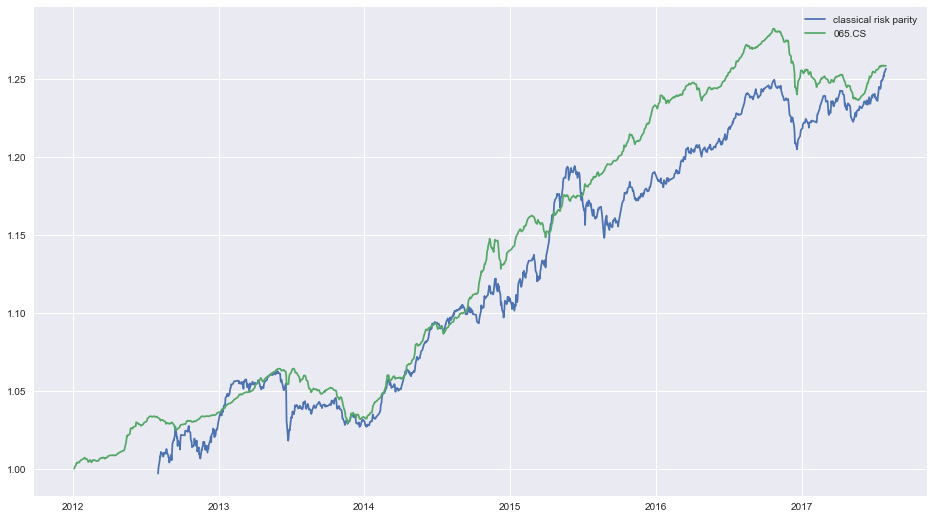

In [198]:
plt.figure(figsize=(16, 9))
plt.plot((1+rp_portfolio_ret).cumprod(), label='classical risk parity')
# plt.plot((1+ret_df['881001.WI']).cumprod(), label='881001.WI')
# plt.plot((1+ret_df['HSI.HI']).cumprod(), label='HSI.HI')
# plt.plot((1+ret_df['SPX.GI']).cumprod(), label='SPX.GI')
plt.plot((1+ret_df['065.CS']).cumprod(), label='065.CS')
# plt.plot((1+ret_df['AU9999.SGE']).cumprod(), label='AU9999.SGE')
# plt.plot((1+ret_df['B.IPE']).cumprod(), label='B.IPE')
plt.legend()

## Risk Parity with Higher Moments

In [236]:
M2 = ret_df.cov()

In [237]:
M3 = calculate_portfolio_coskewness(ret_df)

In [238]:
M4 = calculate_portfolio_cokurtosis(ret_df) 

In [239]:
def risk_budget_objective_higher(x, pars):
    # 计算组合风险
#     N = len(x)
#     x_t = np.array([1./N] * N) # 目标风险贡献相等
    
    M2, M3, M4 = pars[0], pars[1], pars[2]
    lamb2, lamb3, lamb4 = pars[3], pars[4], pars[5]

    var = calculate_portfolio_var(x, M2)
    skew = calculate_portfolio_skewness(x, M3)
    kurt = calculate_portfolio_kurtosis(x, M4)
#     print var
    
    MRC2 = M2.dot(x.T)
    MRC3 = M3.dot(np.kron(x, x))
    MRC4 = M4.dot(np.kron(np.kron(x, x), x))
    
    ARC2 = x * MRC2 / var
    ARC3 = x * MRC3 / skew
    ARC4 = x * MRC4 / kurt
#     print ARC2
    
#     J = lamb2 * np.sum(np.square(ARC2 - x_t)) +\
#         lamb3 * np.sum(np.square(ARC3 - x_t)) +\
#         lamb4 * np.sum(np.square(ARC4 - x_t)) # sum of squared error
#     J = lamb2 * np.sum([(i-j)**2 for i in ARC2 for j in ARC2]) +\
#         lamb3 * np.sum([(i-j)**2 for i in ARC3 for j in ARC3]) +\
#         lamb4 * np.sum([(i-j)**2 for i in ARC4 for j in ARC4])
#     J2 = lamb2 * (x.dot(MRC2) - np.log(x).sum())
#     J3 = lamb3 * (x.dot(MRC3) - np.log(x).sum())
#     J4 = lamb4 * (x.dot(MRC4) - np.log(x).sum())
    J2 = lamb2 * np.sum([(i-j)**2 for i in ARC2 for j in ARC2])
    J3 = lamb3 * np.sum([(i-j)**2 for i in ARC3 for j in ARC3])
    J4 = lamb4 * np.sum([(i-j)**2 for i in ARC4 for j in ARC4])
#     J3 = lamb3 * (ARC3.max() - ARC3.min())
#     print J2, J3, J4
    J = J2 + J3 + J4
#     print J2, J3, J4
#     print J2, J3, J4
#     print J
    return J

In [246]:
# 根据资产预期目标风险贡献度来计算各资产的权重
def calcu_w_higher(M2, M3, M4, lamb2=1, lamb3=1, lamb4=1):
    N = M2.shape[0]
#     w0 = np.random.dirichlet(np.ones(N),size=1) # dirichlet分布作为初始值
#     w0 = np.array([1./N]*N)
#     w0 = np.array([0.01, 0.01, 0.01, 0.95, 0.01, 0.01])
    w0 = np.random.random_sample((N,))
    w0 /= w0.sum()
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
            {'type': 'ineq', 'fun': long_only_constraint})
    minimizer_args = {'method': 'SLSQP', 'args': [M2, M3, M4, lamb2, lamb3, lamb4], 'constraints': cons}
#     res = basinhopping(risk_budget_objective, w0, stepsize=1e-10, minimizer_kwargs=minimizer_args)
#     minimizer_args = {'method': 'L-BFGS-B', 'args': [M2, M3, M4, lamb2, lamb3, lamb4], 'bounds': np.array([(0., None)]*N)}
    res = basinhopping(risk_budget_objective_higher, w0, stepsize=1e-6, minimizer_kwargs=minimizer_args)
#     res = minimize(risk_budget_objective_higher, w0, args=[M2, M3, M4, lamb2, lamb3, lamb4], 
#                    bounds=np.array([(0., None)]*N), method='L-BFGS-B')
    return res.x / res.x.sum()

In [247]:
wb = calcu_w(M2)

881001.WI     4.331430e-07
HSI.HI        4.331393e-07
SPX.GI        4.331410e-07
065.CS        4.331375e-07
AU9999.SGE    4.331460e-07
B.IPE         4.331432e-07
dtype: float64


In [248]:
wb

array([ 0.02824647,  0.043544  ,  0.06275184,  0.76746183,  0.06937659,
        0.02861926])

In [264]:
wb = calcu_w_higher(M2, M3, M4, lamb2=1, lamb3=0, lamb4=1)

In [265]:
wb

array([ 0.02961246,  0.04138807,  0.06027162,  0.76679688,  0.07256213,
        0.02936884])

In [266]:
wb * M2.dot(wb)

881001.WI     4.602311e-07
HSI.HI        4.060961e-07
SPX.GI        4.082130e-07
065.CS        4.323604e-07
AU9999.SGE    4.720945e-07
B.IPE         4.481610e-07
dtype: float64

In [267]:
wb * M3.dot(np.kron(wb, wb))

array([ -2.48268120e-10,  -8.23289769e-11,  -7.41851745e-11,
        -3.30697751e-10,  -7.99369881e-11,   7.30838009e-11])

In [268]:
wb * M4.dot(np.kron(np.kron(wb, wb), wb))

array([  9.04619361e-12,   1.02899609e-11,   1.03397308e-11,
         9.78228949e-12,   8.74971846e-12,   9.33960021e-12])

In [269]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.array([0, 0, 0, 0, 0, 0])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        temp_df = ret_df[ret_df.index <= date][-121:]
        if temp_df.shape[0] < 121:
            continue
        M2 = temp_df.cov()
        M3 = calculate_portfolio_coskewness(temp_df)
        M4 = calculate_portfolio_cokurtosis(temp_df)
        calc_wb = calcu_w_higher(M2, M3, M4, lamb3=0)
        
        risk_contr2 = calc_wb * (M2.dot(calc_wb)).values
        risk_contr3 = calc_wb * (M3.dot(np.kron(calc_wb, calc_wb)))
        risk_contr4 = calc_wb * (M4.dot(np.kron(np.kron(calc_wb, calc_wb), calc_wb)))
#         wb = calc_wb
#         if risk_contr2.max() - risk_contr2.min() < 1e-8:
        if calc_wb[3] > 0.5:
#            risk_contr3.max() - risk_contr3.min() < 1e-10 and\
#            risk_contr4.max() - risk_contr4.min() < 1e-10:
#             print date
#             print risk_contr
            wb = calc_wb
        else:
            print date, risk_contr2, risk_contr2.max() - risk_contr2.min()
#         print wb * M2.dot(wb).values
#         print wb * M3.dot(np.kron(wb, wb))
#         print wb * M4.dot(np.kron(np.kron(wb, wb), wb))
#         print date, calculate_risk_contribution(wb, cov.as_matrix())
#         if date == rebalance_dates[4]:
#             break

2012-08-01 00:00:00 [  2.23067901e-06   2.19608793e-06   2.07587752e-06  -1.96030263e-07
   2.33890196e-06   2.14845639e-06] 2.53493222221e-06
2012-09-03 00:00:00 [  2.13024592e-06   2.08199987e-06   1.97149012e-06  -1.70078638e-07
   2.16667679e-06   2.03381992e-06] 2.33675542294e-06
2012-10-08 00:00:00 [  2.22291804e-06   2.12845934e-06   1.98882714e-06  -2.52948001e-07
   2.16969743e-06   2.13227606e-06] 2.47586604202e-06
2012-11-01 00:00:00 [  2.16665769e-06   2.01399463e-06   1.91837683e-06  -2.48927907e-07
   2.10420228e-06   2.03620325e-06] 2.41558559782e-06
2012-12-03 00:00:00 [  1.89429499e-06   1.76092145e-06   1.65017887e-06  -1.63832067e-07
   1.89247928e-06   1.78698036e-06] 2.05812705546e-06
2013-01-04 00:00:00 [  1.52711628e-06   1.29954389e-06   1.44210874e-06  -6.56054871e-08
   1.51124888e-06   1.43166940e-06] 1.59272176911e-06
2013-03-01 00:00:00 [  1.39893547e-06   1.21994770e-06   1.37741294e-06  -5.00339497e-08
   1.30199723e-06   1.43875114e-06] 1.48878508897e-06

In [319]:
weight.drop_duplicates()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE
2012-01-05,0,0,0,0,0,0
2012-08-02,0.0296881,0.022049,0.0303173,0.864408,0.0358683,0.0176691
2012-09-04,0.0302263,0.0224386,0.0309723,0.862262,0.0364079,0.0176924
2012-10-09,0.0300527,0.0212213,0.0303819,0.862929,0.0388952,0.0165199
2012-11-02,0.0300332,0.0223831,0.0302828,0.861034,0.0393981,0.0168689
2012-12-04,0.0181359,0.0163848,0.0201446,0.898246,0.0354389,0.0116503
2013-01-07,0.0168158,0.018364,0.0219315,0.896091,0.0325029,0.0142947
2013-02-04,0.0178317,0.0250686,0.0287239,0.870831,0.0382982,0.0192465
2013-03-04,0.0147148,0.022243,0.0253133,0.890753,0.0300381,0.016938
2013-04-02,0.013076,0.0199988,0.0221796,0.898109,0.0296123,0.0170247


In [320]:
higher_portfolio_ret = (weight * ret_df).sum(axis=1)

In [321]:
higher_portfolio_ret = higher_portfolio_ret[higher_portfolio_ret != 0]

In [322]:
metric(higher_portfolio_ret)

Annual return: 5.50%
Sharpe ratio: 1.97
Annual volatility: 2.74%
Max drawdown: -3.74%


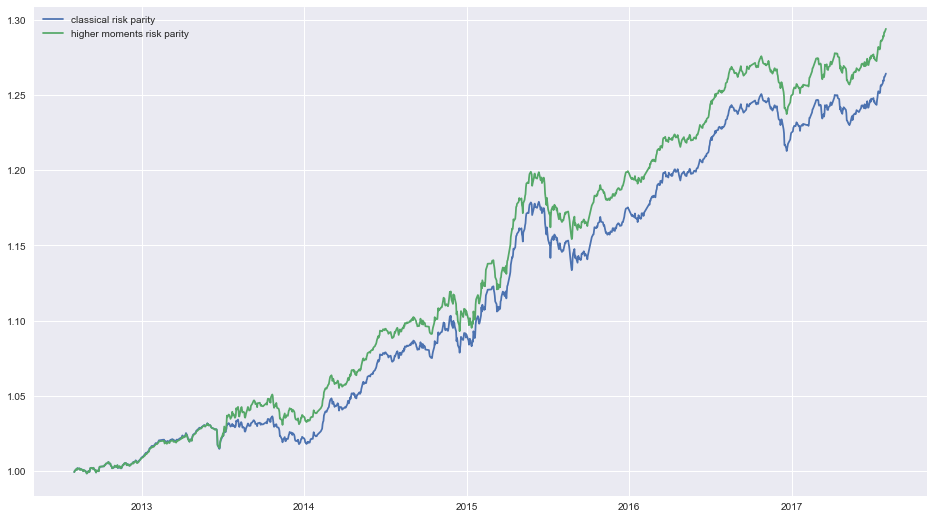

In [323]:
plt.figure(figsize=(16, 9))
plt.plot((1+rp_portfolio_ret).cumprod(), label='classical risk parity')
plt.plot((1+higher_portfolio_ret).cumprod(), label='higher moments risk parity')
# plt.plot((1+ret_df['881001.WI']).cumprod(), label='881001.WI')
# plt.plot((1+ret_df['HSI.HI']).cumprod(), label='HSI.HI')
# plt.plot((1+ret_df['SPX.GI']).cumprod(), label='SPX.GI')
# plt.plot((1+ret_df['065.CS']).cumprod(), label='065.CS')
# plt.plot((1+ret_df['AU9999.SGE']).cumprod(), label='AU9999.SGE')
# plt.plot((1+ret_df['B.IPE']).cumprod(), label='B.IPE')
plt.legend()